## Part 3: Exploratory Data Analysis

**In this notebook,** I explore several aspects of the dataframe and also prepare the dataframe objects for further modeling.

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

## for geospatial
import folium
import geopy
import datetime
from mpl_toolkits.basemap import Basemap

## for machine learning
from sklearn import preprocessing, cluster

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

%matplotlib inline

### Importing the saved clean time-series earthquake data

In [2]:
file_path = "../datasets/" + "combined_eq_california" + "_timeseries" + ".csv"

df_eq = pd.read_csv(file_path)

df_eq = df_eq[["time", "mag", "sig", "longitude", "latitude", "depth"]]

df_eq["time"] = pd.to_datetime(df_eq["time"])
df_eq["timestamps"] = df_eq["time"]
# df_eq.set_index('time', inplace=True)


df_eq

,time,mag,sig,longitude,latitude,depth,timestamps
0,1970-01-02 10:45:20.570,3.14,152,-119.695667,34.206000,6.000000,1970-01-02 10:45:20.570
1,1970-01-02 21:47:53.740,2.61,105,-117.733667,35.735167,1.650000,1970-01-02 21:47:53.740
2,1970-01-03 02:51:58.400,4.00,246,-122.088000,37.298000,6.274206,1970-01-03 02:51:58.400
3,1970-01-03 19:48:40.840,3.16,154,-116.830500,33.960500,6.000000,1970-01-03 19:48:40.840
4,1970-01-04 02:27:15.700,2.74,116,-116.843333,34.333500,6.000000,1970-01-04 02:27:15.700
...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.970000,2020-10-01 15:00:48.340
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.110000,2020-10-01 15:10:23.760
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.650000,2020-10-01 15:12:42.120
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.290000,2020-10-01 15:21:41.480


In [3]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 16.7 MB


## Important: need to drop repetitive rows (10 rows). There were some overlaps in original data.

In [4]:
df_eq[df_eq.duplicated('timestamps')]

,time,mag,sig,longitude,latitude,depth,timestamps


In [5]:
# Dropping rows
df_eq = df_eq.drop_duplicates(subset=['timestamps'])

df_eq["timestamps"].diff().describe()

count                       313331
mean     0 days 01:25:11.019876935
std      0 days 02:33:43.027017800
min         0 days 00:00:00.009000
25%         0 days 00:08:25.260000
50%         0 days 00:36:55.740000
75%         0 days 01:45:43.790000
max         8 days 04:01:06.380000
Name: timestamps, dtype: object

In [6]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 19.1 MB


## Feature engineering

In [7]:
# Number 1: Time intervals between consecutive earthquakes.
df_eq["time_diff"] = df_eq["timestamps"].diff()

df_eq["time_diff_float"] = df_eq["time_diff"].apply(lambda x: x.total_seconds())

#Number 2: the rolling of magnitudes from the last 10 earthquakes

df_eq["mag_roll_10"] = df_eq["mag"].rolling(window=10).mean()

df_eq.dropna(inplace = True)

In [8]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,313323,2.50313,0.510172,2,2.14,2.35,2.7,7.3
sig,313323,101.847,56.3927,62,70,85,112,2910
longitude,313323,-118.583,3.33437,-131.771,-121.236,-118.096,-116.32,-107.001
latitude,313323,37.0011,4.0049,24.007,34.052,36.1962,38.8195,50
depth,313323,6.27424,6.20748,-3.5,2.232,5.385,8.777,257
time_diff,313323,0 days 01:25:09.914685356,0 days 02:33:38.876407841,0 days 00:00:00.009000,0 days 00:08:25.235000,0 days 00:36:55.720000,0 days 01:45:43.478000,8 days 04:01:06.380000
time_diff_float,313323,5109.91,9218.88,0.009,505.235,2215.72,6343.48,705666
mag_roll_10,313323,2.50314,0.226073,2.043,2.354,2.46,2.597,4.826


### 600 days without any recorded earthquakes:

In [9]:
df_eq[df_eq["time_diff_float"] > 86400].shape

(608, 10)

In [10]:
df_eq[df_eq["time_diff_float"] > 86400]

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
18,1970-01-11 13:50:41.420,2.24,77,-118.420167,35.492500,6.00,1970-01-11 13:50:41.420,1 days 02:05:15.740000,93915.74,2.841
37,1970-01-18 00:01:09.770,2.37,86,-117.290500,34.284167,5.81,1970-01-18 00:01:09.770,1 days 09:10:07.190000,119407.19,2.838
38,1970-01-19 07:16:25.380,4.49,310,-115.982000,31.882333,6.00,1970-01-19 07:16:25.380,1 days 07:15:15.610000,112515.61,3.007
42,1970-01-21 11:23:52.610,4.02,249,-115.978833,32.319667,6.00,1970-01-21 11:23:52.610,1 days 00:59:55.410000,89995.41,2.980
44,1970-01-23 16:30:01.120,3.97,242,-116.036833,37.137333,0.30,1970-01-23 16:30:01.120,1 days 13:37:46.280000,135466.28,3.060
...,...,...,...,...,...,...,...,...,...,...
303252,2019-09-02 01:53:55.010,2.41,89,-115.858667,33.902833,2.17,2019-09-02 01:53:55.010,1 days 03:59:44.940000,100784.94,2.321
305041,2020-01-02 00:42:09.750,2.27,79,-118.933500,37.638000,6.18,2020-01-02 00:42:09.750,1 days 02:23:48.590000,95028.59,2.269
305681,2020-03-02 00:31:07.620,2.43,91,-122.212333,40.926667,9.55,2020-03-02 00:31:07.620,1 days 02:11:00.190000,94260.19,2.484
309776,2020-06-02 00:30:49.240,2.01,62,-115.650500,33.154000,3.37,2020-06-02 00:30:49.240,1 days 01:25:13.490000,91513.49,2.450


In [11]:
min_date = df_eq["time"].min().date()

min_date

datetime.date(1970, 1, 7)

In [12]:
max_date = df_eq["time"].max().date()

max_date

datetime.date(2020, 10, 1)

In [13]:
type(df_eq["time"].max().date())

datetime.date

In [14]:
#https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python

start_date = min_date

number_of_days = (max_date - min_date).days
print("number_of_days", number_of_days)
date_list = []
for day in range(number_of_days):
  a_date = (start_date + datetime.timedelta(days = day))
  date_list.append(a_date)

print(date_list[1], type(date_list[0]))

number_of_days 18530
1970-01-08 <class 'datetime.date'>


In [15]:
df_eq

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
9,1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263
10,1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189
11,1970-01-07 18:04:50.000,3.07,145,-120.980667,34.607000,6.00,1970-01-07 18:04:50.000,0 days 14:39:23.890000,52763.89,3.235
12,1970-01-08 02:16:41.350,2.75,116,-117.139833,34.307833,6.00,1970-01-08 02:16:41.350,0 days 08:11:51.350000,29511.35,3.110
13,1970-01-08 17:00:33.860,3.70,211,-121.565833,34.574333,6.00,1970-01-08 17:00:33.860,0 days 14:43:52.510000,53032.51,3.164
...,...,...,...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.97,2020-10-01 15:00:48.340,0 days 00:11:30.200000,690.20,2.536
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.11,2020-10-01 15:10:23.760,0 days 00:09:35.420000,575.42,2.540
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.65,2020-10-01 15:12:42.120,0 days 00:02:18.360000,138.36,2.437
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.29,2020-10-01 15:21:41.480,0 days 00:08:59.360000,539.36,2.488


In [16]:
df_eq.set_index('time', inplace=True)

In [17]:
df_daily = pd.DataFrame() 
# AS is year-start frequency
df_daily['mag_day_max'] = df_eq.mag.resample('D').max() # What is the max of events
df_daily['event_day_count'] = df_eq.mag.resample('D').count() #How many events happened
df_daily['mag_day_mean'] = df_eq.mag.resample('D').mean() #What is the mean of values for that particular day
df_daily['mag_day_sum'] = df_eq.mag.resample('D').sum() # What is the sum of moments
df_daily['mag_day_scatter'] = (df_eq.mag.resample('D').std()) # What is the scatter of event magnitudes
df_daily["mag_day_roll_10"] = df_daily["mag_day_mean"].rolling(window=10).mean()


df_daily['longitude_day_mean'] = df_eq.longitude.resample('D').mean() #Mean location of events 
df_daily['longitude_day_std'] = df_eq.longitude.resample('D').std() #Std location of events 

df_daily['latitude_day_mean'] = df_eq.latitude.resample('D').mean() #Mean location of events 
df_daily['latitude_day_std'] = df_eq.latitude.resample('D').std() #Std location of events 

df_daily['depth_day_mean'] = df_eq.depth.resample('D').mean() #Mean location of events 
df_daily['depth_day_std'] = df_eq.depth.resample('D').std() #Std location of events 

df_daily['time_diff_float_day_mean'] = df_eq.time_diff_float.resample('D').mean() #Event spacing 
df_daily['time_diff_float_day_std'] = df_eq.time_diff_float.resample('D').std() #Std location of events 


df_daily

,mag_day_max,event_day_count,mag_day_mean,mag_day_sum,mag_day_scatter,mag_day_roll_10,longitude_day_mean,longitude_day_std,latitude_day_mean,latitude_day_std,depth_day_mean,depth_day_std,time_diff_float_day_mean,time_diff_float_day_std
time,,,,,,,,,,,,,,
1970-01-07,3.31,3,2.926667,8.78,0.471628,NaN,-118.150056,2.617310,34.005444,2.176113,5.886667,0.196299,23733.110000,25179.320539
1970-01-08,3.70,2,3.225000,6.45,0.671751,NaN,-119.352833,3.129655,34.441083,0.188444,6.000000,0.000000,41271.930000,16631.971737
1970-01-09,2.44,1,2.440000,2.44,NaN,NaN,-118.610167,NaN,35.397000,NaN,6.000000,NaN,43656.790000,NaN
1970-01-10,3.03,3,2.833333,8.50,0.290230,NaN,-117.889444,1.413732,38.679556,7.140646,4.788667,2.893839,36745.010000,33802.932830
1970-01-11,3.37,6,2.566667,15.40,0.564151,NaN,-119.576389,1.766064,35.231611,0.419287,5.928333,0.404496,19058.731667,37098.376200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,3.42,14,2.392143,33.49,0.439496,2.489418,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,3.48,14,2.337857,32.73,0.407340,2.471204,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,3.90,22,2.612273,57.47,0.494579,2.491639,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


In [18]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18531 entries, 1970-01-07 to 2020-10-01
Freq: D
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mag_day_max               18094 non-null  float64
 1   event_day_count           18531 non-null  int64  
 2   mag_day_mean              18094 non-null  float64
 3   mag_day_sum               18531 non-null  float64
 4   mag_day_scatter           17707 non-null  float64
 5   mag_day_roll_10           15494 non-null  float64
 6   longitude_day_mean        18094 non-null  float64
 7   longitude_day_std         17707 non-null  float64
 8   latitude_day_mean         18094 non-null  float64
 9   latitude_day_std          17707 non-null  float64
 10  depth_day_mean            18094 non-null  float64
 11  depth_day_std             17707 non-null  float64
 12  time_diff_float_day_mean  18094 non-null  float64
 13  time_diff_float_day_std   17707 non-

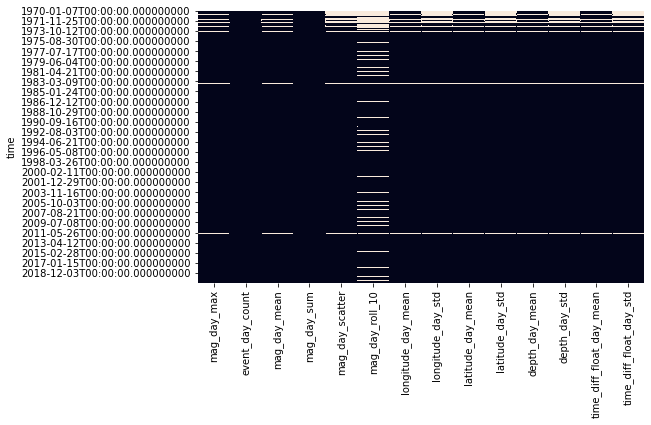

In [19]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily.isnull(), cbar=False)

In [20]:
df_daily_clean = df_daily[df_daily.index > "1972-01-01"]

df_daily_clean.drop(columns = ["mag_day_roll_10"], inplace = True)

df_daily_clean

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,mag_day_max,event_day_count,mag_day_mean,mag_day_sum,mag_day_scatter,longitude_day_mean,longitude_day_std,latitude_day_mean,latitude_day_std,depth_day_mean,depth_day_std,time_diff_float_day_mean,time_diff_float_day_std
time,,,,,,,,,,,,,
1972-01-02,2.90,2,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.193500,10.173145,64877.640000,90530.909480
1972-01-03,4.60,1,4.600000,4.60,NaN,-112.170000,NaN,38.650000,NaN,7.000000,NaN,105546.310000,NaN
1972-01-04,2.30,1,2.300000,2.30,NaN,-123.153333,NaN,47.200833,NaN,15.401000,NaN,81088.790000,NaN
1972-01-05,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-01-06,3.54,3,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.980000,3.266298,66695.046667,73587.754649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,3.42,14,2.392143,33.49,0.439496,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,3.48,14,2.337857,32.73,0.407340,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,3.90,22,2.612273,57.47,0.494579,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


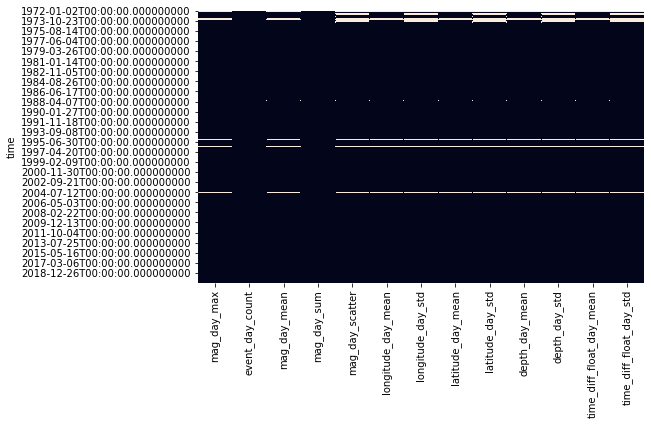

In [21]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily_clean.isnull(), cbar=False)

In [22]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mag_day_max               17498 non-null  float64
 1   event_day_count           17806 non-null  int64  
 2   mag_day_mean              17498 non-null  float64
 3   mag_day_sum               17806 non-null  float64
 4   mag_day_scatter           17308 non-null  float64
 5   longitude_day_mean        17498 non-null  float64
 6   longitude_day_std         17308 non-null  float64
 7   latitude_day_mean         17498 non-null  float64
 8   latitude_day_std          17308 non-null  float64
 9   depth_day_mean            17498 non-null  float64
 10  depth_day_std             17308 non-null  float64
 11  time_diff_float_day_mean  17498 non-null  float64
 12  time_diff_float_day_std   17308 non-null  float64
dtypes: float64(12), int64(1)
memory usag

## Imputing the missing values:

In [23]:
#Source: https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
df_daily_clean.interpolate('time', inplace = True)
df_daily_clean.head(2)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mag_day_max,event_day_count,mag_day_mean,mag_day_sum,mag_day_scatter,longitude_day_mean,longitude_day_std,latitude_day_mean,latitude_day_std,depth_day_mean,depth_day_std,time_diff_float_day_mean,time_diff_float_day_std
time,,,,,,,,,,,,,
1972-01-02,2.9,2,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480
1972-01-03,4.6,1,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772


In [24]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mag_day_max               17806 non-null  float64
 1   event_day_count           17806 non-null  int64  
 2   mag_day_mean              17806 non-null  float64
 3   mag_day_sum               17806 non-null  float64
 4   mag_day_scatter           17806 non-null  float64
 5   longitude_day_mean        17806 non-null  float64
 6   longitude_day_std         17806 non-null  float64
 7   latitude_day_mean         17806 non-null  float64
 8   latitude_day_std          17806 non-null  float64
 9   depth_day_mean            17806 non-null  float64
 10  depth_day_std             17806 non-null  float64
 11  time_diff_float_day_mean  17806 non-null  float64
 12  time_diff_float_day_std   17806 non-null  float64
dtypes: float64(12), int64(1)
memory usag

### Putting back the dataframe into original DataFrame aamd do stuff

In [25]:
df_eq = df_daily_clean
df_eq.shape

(17806, 13)

# Loma Prieta

In [41]:
df_eq_sel_range = df_eq['1985-09-19':'1989-10-19']

In [75]:
cluster_data = {"cluster_density": 0, "cluster_mag_max_mean": 0, "cluster_mag_max_max": 0, 
                "cluster_long_cent": 0, "cluster_long_std": 0, "cluster_lat_cent": 0, "cluster_lat_std": 0,
                "cluster_dept_cent": 0, "cluster_dept_std": 0
       }


cluster_data = pd.DataFrame(cluster_data, index=[0])




df_cluster_daily = df_eq_sel_range.copy()


eps_param = 0.33
min_sample = 7


for i in range(5 * min_sample, 5 * min_sample+1):#len(df_cluster_daily)):

    # Building cluster
    df_ = df_cluster_daily.iloc[:i,:]
    
    ss = StandardScaler()

    X_scaled = ss.fit_transform(df_.loc[:,["longitude_day_mean", "latitude_day_mean", "depth_day_mean"]])

    dbscan = DBSCAN(
                    eps = eps_param, 
                    min_samples = min_sample
                    )

    dbscan.fit(X_scaled);

    df_['cluster'] = dbscan.labels_

    # Getting the top cluster
    Top_clusters = df_.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:].index

    if (len(Top_clusters) == 1) & (Top_clusters[0] == -1):
        rows = [-1] * (cluster_data).shape[1]
    else:
        
        if (Top_clusters[0] < 0):
            cluster_mask = Top_clusters[1]
        else:
            cluster_mask = Top_clusters[0]

        df_selected = df_[df_["cluster"] == cluster_mask]


        max_long = df_selected["longitude_day_mean"].max()
        min_long = df_selected["longitude_day_mean"].min()
        max_lat = df_selected["latitude_day_mean"].max()
        min_lat = df_selected["latitude_day_mean"].min()
        area = (max_lat - min_lat)*(max_long - min_long)
        cluster_density = area / len(df_selected)

        cluster_mag_max_mean = df_selected["mag_day_max"].mean()
        cluster_mag_max_max = df_selected["mag_day_max"].max()

        cluster_long_cent = df_selected["longitude_day_mean"].mean()

        cluster_long_std = df_selected["longitude_day_mean"].std()

        cluster_lat_cent = df_selected["latitude_day_mean"].mean()

        cluster_lat_std = df_selected["latitude_day_mean"].std()

        cluster_dept_cent = df_selected["depth_day_mean"].mean()

        cluster_dept_std = df_selected["depth_day_mean"].std()

        rows = [cluster_density, cluster_mag_max_mean, cluster_mag_max_max,
                cluster_long_cent, cluster_long_std, cluster_lat_cent, cluster_lat_std,
                cluster_dept_cent, cluster_dept_std
                          ]
    
    cluster_data.loc[i] = rows
#     cluster_df.loc[len(cluster_df)] = rows

# cluster_df.drop(cluster_df.index[0], inplace=True)


# df_cluster_daily[""]




# cluster_df["long_mov"] = cluster_df["long_cent"].diff()
# cluster_df["lat_mov"] = cluster_df["long_cent"].diff()

# cluster_df.dropna(inplace = True)


# cluster_df.reset_index(inplace=True)

# cluster_df.drop(columns = "index", inplace=True)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
cluster_data

,cluster_density,cluster_mag_max_mean,cluster_mag_max_max,cluster_long_cent,cluster_long_std,cluster_lat_cent,cluster_lat_std,cluster_dept_cent,cluster_dept_std
0,0,0,0,0,0,0,0,0,0
35,-1,-1,-1,-1,-1,-1,-1,-1,-1
